# Meta'omics for Ocean Science

Ocean Hack Week 2023 Tutorial by Julia M Brown

![scales](./tutorial_images/rainbow_satellite_to_microbe.png)  

With thanks to the following for content and inspiration:  
[Greg Gavelis](https://github.com/ggavelis), [Joe Brown](https://github.com/brwnj), [Maria Pachiadaki](https://github.com/microbiaki), [Ramunas Stepanauskas](https://www.bigelow.org/about/people/rstepanauskas.html), [MerenLab](https://merenlab.org/), [Kaiju Team](https://bioinformatics-centre.github.io/kaiju/), [Cath Mitchell](https://github.com/MarineOpticsLab)



### What is 'omics data?

* Data on biological molecules  
* 'Meta' refers to collecting and processing samples in bulk 
* Data often focused on specific **unicellular** size fractions  

### How is it generated?

* Collection of sample in bulk.  
* For planktonic microbes, samples are collected based on a specific size fraction that targets different microbial groups
    * e.g. bacteria and archaea, protists, phytoplankton, viruses  
* Nucleic acids, proteins or other target molecules extracted and sequenced 
* For nucleotide data (DNA + RNA), samples often sequenced via Illumina sequencing
    * generates short __paired end__ reads 
    * reads can be characterized directly or used to assemble larger __contiguous sequences__

![omics](./tutorial_images/metaXomics_diagram.png)  

### It can tell us the who and what of microbial communities

**Metagenome (DNA)** : Presence and potential  
**Metatranscriptome (RNA)**: Activity  

**Taxonomy:**  

* What microbes are present -- DNA
* Which microbes are active -- RNA

**Function:**

* What is the metabolic potential? -- DNA
* What processes are being carried out? -- RNA

### What does it look like?  

* fastq - raw sequence read data with quality information included
* fasta - sequence data, can be contiguous sequences, open reading frames (i.e. coding sequences) or protein sequences



### How can we use raw reads?

**Read profiling** is one of the most commonly used processes in 'omics analysis. It is applied to access the relative abundance of taxonomic groups within metagenomic datasets (when using DNA metagenomes) or to estimate the expression of different microbial taxa (when RNA metatranscriptomes are used).

In a nutshell short reads are aligned to a genomic reference sequences, which have taxonomic information assigned to them that may be assigned to the reads.

![recruitment](./tutorial_images/01-metagenomic-read-recruitment-simple.gif)  
(Thank you [MerenLab](https://merenlab.org/) for the animation)

# Read classification tools

# [Kaiju](https://kaiju.binf.ku.dk/server)
![Kaiju](https://kaiju.binf.ku.dk/images/kaiju3_header.gif)

**Also: [Kraken2](https://github.com/DerrickWood/kraken2/)**

These workflows are wicked fast!

### How do they work?

**Database**  
Database consists of a collection of translated proteins mapped to microbial genomes.

<img src="./tutorial_images/proteins_to_genomes.png" alt="p2g" width="400"/>

### Short read alignment

Reads are translated into protein sequences and aligned to reference protein sequences. Best matches to proteins are then taxonomically assigned based on protein's membership in microbial genomes.

![kaiju_diagram](./tutorial_images/short_read_align.png)

## Tools are as good as your reference database

Kaiju and other classifiers rely on genome databases that primarily contain genomes from isolated microbes and genomes assembled from metagenomes ('MAGs').

**Available Standard Kaiju Databases**  
<img src="https://upload.wikimedia.org/wikipedia/commons/0/07/US-NLM-NCBI-Logo.svg" alt="ncbi" width="100"/>

**nr**: Non-redundant proteins from bacteria, archaea and viruses  
**RefSeq**: Curated bacterial, archaeal and viral genomes from NCBI

<img src="https://progenomes.embl.de/img/progene_head21.png" alt="progenomes" width="300"/>  

**ProGenomes**: Database of microbial genomes including MAGs from diverse environments

**Note:** Kaiju has other available databases that could be useful for your environment or organisms of interest. See their website for more options.  

**Database Limitations**: Despite the depth of these collections, they leave stones unturned. Microbial genomic diversity is high in marine systems and genomes assembled from short reads represent only a fraction of the microbial diversity present in the ocean!

## SAGs

Single Cell Genomics is another type of 'omics data that is well suited for reference genomic data. It consists of DNA sequence data generated from the DNA present in single cells.  Each set of data from each cell is referred to as a __Single Amplified Genome (i.e. SAG)__. SAGs represent real biological units recovered from samples, and contain genomic information specific to individuals.

<img src="./tutorial_images/scg_diagram.png" alt="sag" width="800"/>

## GORG-Tropics: A collection of reference genomes from individual cells from the Tropical and Sub-tropical Epipelagic Ocean

GORG-Tropics is more representative of global ocean microbes than MAGs or currently available reference genomes*.

*I am not sure if GORG-Tropics has been integrated into ProGenomes or not

![GORG-Figure2](https://ars.els-cdn.com/content/image/1-s2.0-S0092867419312735-gr2.jpg)  


GORG-Tropics is more accurate and sensitive than default databases used for read classification by Kaiju when analyzing marine epipelagic samples. When GORG-Tropics used as a database for reads from similar environments, many more were able to be correctly classified. 

![GORG-Figure](https://ars.els-cdn.com/content/image/1-s2.0-S0092867419312735-gr6.jpg)  

The other advantage of using a tailored database is that it takes up less storage space :)


### Database Setup

For this tutorial we'll be using the GORG-Tropics database. This database is published alongside [this publication](https://www.sciencedirect.com/science/article/pii/S0092867419312735), and in a data repository [here](https://osf.io/pcwj9/).

Specific database files used for this tutorial are:  
[GORG_v1_CREST.fmi](https://osf.io/a3428)  
[nodes.dmp](https://osf.io/a8bm5)  
[names.dmp](https://osf.io/cqrh4)  

Note that I am going to show you this workflow in steps using kaiju, BUT the entire kaiju workflow using the GORG-Tropics database is packaged into a docker/singularity container and can be run with nextflow for easy access and for scalability. You can find it [here](https://github.com/BigelowLab/gorg-classifier). 

The GORG-Classifier provides additional functionality beyond Kaiju to assign **functional annotations** to reads based on what specific gene was matched in the GORG-Tropics Database. This is unique to this tool. 

Today, I'm going to go over taxonomic annotation of reads.

## Data Prep

We will be running Kaiju on a collection of epipelagic metagenomes from the Bermuda Atlantic Time Series using version 1 of the GORG-Tropics database.


For this lesson, we look at microbial community dynamics over time at BATs using short read alignment with Kaiju against the GORG-Tropics database.

The metagenomes we will use are a small subset of metagenomes reported in [this](https://www.nature.com/articles/sdata2018176) publication. These metagenomes are available in NCBI's Short Read Archive (sra) through NCBI project ID [PRJNA385855](https://www.ncbi.nlm.nih.gov/bioproject?term=PRJNA385855). I've downloaded a metadata sheet with all sra metagenomes from this bioproject to: ./data/PRJNA385855_sra_metadata.csv

Let's check this table out, and I'll show you which metagenomes I selected.

In [90]:
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op

from sklearn.decomposition import PCA
from collections import Counter

In [1]:
df = pd.read_csv("./data/PRJNA385855_sra_metadata.csv", sep = ",")

df.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,bottle_id,Bytes,Center Name,...,lat_lon,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample Name,SRA Study
0,SRR6507277,WGS,300,16133582100,PRJNA385855,SAMN08390922,"MIMS.me,MIGS/MIMS/MIMARKS.water",2140200308,6618578156,MIT,...,22.75 N 158 W,S0627,PAIRED,RANDOM,METAGENOMIC,marine metagenome,ILLUMINA,2018-05-01T00:00:00Z,S0627,SRP109831
1,SRR6507278,WGS,300,15874959000,PRJNA385855,SAMN08390923,"MIMS.me,MIGS/MIMS/MIMARKS.water",2160200304,6562862443,MIT,...,22.75 N 158 W,S0628,PAIRED,RANDOM,METAGENOMIC,marine metagenome,ILLUMINA,2018-05-01T00:00:00Z,S0628,SRP109831
2,SRR6507279,WGS,300,15069825300,PRJNA385855,SAMN08390924,"MIMS.me,MIGS/MIMS/MIMARKS.water",1024800503,6265839401,MIT,...,31.66 N 64.16 W,S0629,PAIRED,RANDOM,METAGENOMIC,marine metagenome,ILLUMINA,2018-05-01T00:00:00Z,S0629,SRP109831
3,SRR6507280,WGS,300,25807308000,PRJNA385855,SAMN08390925,"MIMS.me,MIGS/MIMS/MIMARKS.water",1025200510,10523504402,MIT,...,31.66 N 64.16 W,S0630,PAIRED,RANDOM,METAGENOMIC,marine metagenome,ILLUMINA,2018-05-01T00:00:00Z,S0630,SRP109831
4,SRR5720219,WGS,300,6713331000,PRJNA385855,SAMN07137016,"MIMS.me,MIGS/MIMS/MIMARKS.water",1640201117,2811014041,MIT,...,22.75 N 158 W,S0519,PAIRED,RANDOM,METAGENOMIC,marine metagenome,ILLUMINA,2018-05-01T00:00:00Z,S0519,SRP109831


There's a lot of information here, for now, we just need the 'Run' ID so that we can use it to grab data from NCBI, as well as the collection date and depth.

In [2]:
# selecting surface samples collected from BATS
surface_bats = df[df['cruise_id'].str.contains('BATS') & df['Depth'].isin(['10m','1m'])][['Run','Collection_date','cruise_id','BioSample','Depth']].sort_values(by = 'Collection_date')

print('There are', len(surface_bats), 'metagenomes')
surface_bats

There are 21 metagenomes


,Run,Collection_date,cruise_id,BioSample,Depth
74,SRR5720233,2003-02-21,BATS173,SAMN07137079,1m
14,SRR5720238,2003-03-22,BATS174,SAMN07137082,1m
119,SRR5720327,2003-04-22,BATS175,SAMN07137064,10m
99,SRR5720283,2003-05-20,BATS176,SAMN07137103,1m
75,SRR5720235,2003-07-15,BATS178,SAMN07137085,10m
38,SRR5720286,2003-08-12,BATS179,SAMN07137088,10m
64,SRR5720332,2003-10-07,BATS181,SAMN07137067,1m
96,SRR5720276,2003-11-04,BATS182,SAMN07137106,1m
90,SRR5720262,2003-12-02,BATS183,SAMN07137109,1m
124,SRR5720338,2004-01-27,BATS184,SAMN07137070,1m


Let's just focus on one year to make things simple.


In [3]:
# grab only samples from 2004
# naming it mgoi for 'metagenomes of interest'
mgoi = surface_bats[surface_bats['Collection_date'].str.contains('2004')]
len(mgoi)

11

In [4]:
# going to save this table to file
mgoi.to_csv("./data/bats_metagenomes_of_interest.csv", index=False)

# I also saved a text file with one metagenome ID per line for downloading these metagenomes with a shell script
with open('data/metagenomes_to_download.txt', 'w') as oh:
    for run in mgoi['Run']:
        print(run, file = oh)

I next downloaded these metagenomes from NCBI using a package called [fastq-dl](https://github.com/rpetit3/fastq-dl). These metagenomes are large, and downloading them takes a while, so I did this overnight using a small shell script:

```
cd ./data/

while read p; 
    do fastq-dl -a $p --provider sra; 
done < metagenomes_to_download.txt
```

This downloads a set of paired reads files that look like this:

```
{RunID}_1.fastq.gz
{RunID_2}.fastq.gz
```

Each file is between 1 and 3G in size. For the purposes of this tutorial, I subsampled these paired metagenomes down to 100000k reads per metagenome using a package called [seqtk](https://github.com/lh3/seqtk). I ran this in a jupyter notebook. The script I used to do this was:

```
%%python
import glob

ffqs = glob.glob("*_1.fastq.gz")

for f in ffqs:
    r = f.replace('_1','_2')
    
    outf = "./subsampled_metagenomes/{}".format(f.replace("_1.fastq.gz",
                                                          '_100ksub_1.fastq.gz'))
    outr = "./subsampled_metagenomes/{}".format(r.replace("_2.fastq.gz",
                                                          '_100ksub_2.fastq.gz'))
    
    !seqtk sample -s 123 {f} 100000 > {outf}
    
    !seqtk sample -s 123 {r} 100000 > {outr}
```

The important command is ```seqtk sample -s 123 {infastq} 100000 > {outfastq}```. 

The script randomly subsamples a subset of reads. I needed to do this for paired metagenomic data, so to make sure the samples were random but consistent between the paired files I used the ```-s``` parameter to set the seed for random sampling. After the ```-s``` parameter (which can be any integer), I provide the input fastq file and then the number of reads I would like to subsample from the input file, I then send the output to a new file. 

### Running Kaiju

This happens in two steps. In the first step the reads are mapped to the database, and in the second step, taxonomy is assigned to each read based on how they mapped.  

Note: The first step takes much longer than the second.

Let's run this for an example genome, using only 10k reads:

In [4]:
database_nodes = '/home/jovyan/shared/omics_tutorial/kaiju_db/nodes.dmp'
database_names = database_nodes.replace('nodes','names')
database = '/home/jovyan/shared/omics_tutorial/kaiju_db/GORG_v1_CREST.fmi'
fq1 = '/home/jovyan/shared/omics_tutorial/10k_subsampled_metagenomes/SRR5720233_10ksub_1.fastq.gz'
fq2 = fq1.replace("_1.tar.gz", "_2.tar.gz")
out = op.join(op.basename(fq1).replace('_1.fastq.gz','_vs_GORGv1_kaiju.out'))
out_tax = out.replace('.out','_wtaxonomy.out')

```
!kaiju -t {database_nodes} \
-f {database} \
-i {fq1} \
-j {fq2} \
-o {out} \
-v

!kaiju-addTaxonNames -t {database_nodes} \
-n {database_names} \
-i {out} \
-o {out_tax} \
-r superkingdom,phylum,class,order,family,genus,species
```

The above will likely work on your local machine if you have a good amount of RAM, but it takes up too much RAM for the OHW jupyterhub, so pretend you've run this, and we'll move on from there!

### Exploring Results

Disclaimer: I am visualizing the results of Kaiju with python today, BUT there are some great tools available through R's [phyloseq package](https://joey711.github.io/phyloseq/).

If I do this tutorial next year, I will begrudgingly learn how to do this (and more!) using R packages, but today you're going to get some python.

In [101]:

out_tax = "/home/jovyan/shared/omics_tutorial/kaiju_results/results/SRR5720342_100ksub_vs_GORGv1_kaiju_wtaxonomy.out"

odf = pd.read_csv(out_tax, 
                  sep = "\t", 
                  names = ['status','read_id','tax_id','taxonomy'])

odf.head()

,status,read_id,tax_id,taxonomy
0,U,SRR5720342.29508414,0,NaN
1,U,SRR5720342.14562609,0,NaN
2,U,SRR5720342.3034975,0,NaN
3,C,SRR5720342.6694984,1754,Bacteria; Cyanobacteria; Oxyphotobacteria; Syn...
4,C,SRR5720342.20247457,2547,Bacteria; Proteobacteria; Gammaproteobacteria;...


The ouput table has four columns:  

> **status**: whether the read was classified (C) or unclassified (U)  
> **read_id**: ID of the mapped read  
> **tax_id**: taxonomic ID of mapped read  
> **taxonomy**: taxonomy of mapped read

How many reads were classified?

In [102]:
print(round(odf['status'].value_counts()['C'] / len(odf) * 100, 1), 
      'percent of reads were able to be classified.')

44.6 percent of reads were able to be classified.


What does it mean for a read to be classified? 

It means that a read aligned to a protein from a genome in the database, and a taxonomic annotation was assigned.

![microbial_taxonomy](https://upload.wikimedia.org/wikipedia/commons/a/a5/Biological_classification_L_Pengo_vflip.svg)

In the output taxonomic data from Kaiju, the rank order is a little bit different from this diagram:

* superkingdom
* phylum
* class
* order
* family
* genus
* species

In the Kaiju output table, the taxonomic ranks are all shown in the 'taxonomy' column, with each rank separated by a ';'

In [103]:
# look at 10 most common taxonomic classifications

Counter(odf['taxonomy']).most_common()[:10]

[(nan, 55360),
 ('Bacteria; Proteobacteria; Alphaproteobacteria; SAR11 clade; Surface 1; NA; NA; ',
  9733),
 ('Bacteria; Cyanobacteria; Oxyphotobacteria; Synechococcales; Synechococcaceae; Prochlorococcus; NA; ',
  5787),
 ('Bacteria; Proteobacteria; Gammaproteobacteria; Oceanospirillales; SAR86 clade; NA; NA; ',
  4137),
 ('Bacteria; Proteobacteria; Alphaproteobacteria; Rickettsiales; SAR116 clade; NA; NA; ',
  2288),
 ('Bacteria; Proteobacteria; Alphaproteobacteria; Rhodospirillales; Rhodospirillaceae; AEGEAN-169 marine group; NA; ',
  2227),
 ('Bacteria; Proteobacteria; Alphaproteobacteria; Rhodobacterales; Rhodobacteraceae; NA; NA; ',
  2191),
 ('Bacteria; Proteobacteria; Alphaproteobacteria; SAR11 clade; Surface 2; NA; NA; ',
  1404),
 ('Bacteria; Marinimicrobia (SAR406 clade); NA; NA; NA; NA; NA; ', 1251),
 ('Bacteria; Bacteroidetes; Flavobacteriia; Flavobacteriales; Flavobacteriaceae; NS5 marine group; NA; ',
  1124)]

There are instances where the available classification does not go all the way down to species.  This happens either if the reference genome that the read hit is not classified to that level, or if the read had equivalent matches to references from two different taxonomic categories.  In this case Kaiju assigns the read to the __last common ancestor__ of the two reads.

<img src="tutorial_images/phlyo_diagram.png" alt="lca_example" width="400"/>  

For example, in the above diagram, if a read hit proteins in both Species A and Species C, the read would be classified to the Family level, because that is their last common ancestral node.

Sometimes, we want to examine distributions at specific taxonomic levels, so let's split taxonomy column up into new columns, one for each taxonomic level.
(notice that the taxonomic string used is the same as what we entered when we ran ```kaiju-addTaxonNames```)

In [105]:
def get_rank(t, index_val):
    if type(t) is str:
        return t.split(';')[index_val].lstrip()
    else:
        return t
        
for j, rank in enumerate('superkingdom,phylum,class,order,family,genus,species'.split(',')):
    odf[rank] = odf['taxonomy'].apply(lambda t: (get_rank(t, j)))

odf.head()

,status,read_id,tax_id,taxonomy,superkingdom,phylum,class,order,family,genus,species
0,U,SRR5720342.29508414,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U,SRR5720342.14562609,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U,SRR5720342.3034975,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C,SRR5720342.6694984,1754,Bacteria; Cyanobacteria; Oxyphotobacteria; Syn...,Bacteria,Cyanobacteria,Oxyphotobacteria,Synechococcales,Synechococcaceae,Prochlorococcus,NA
4,C,SRR5720342.20247457,2547,Bacteria; Proteobacteria; Gammaproteobacteria;...,Bacteria,Proteobacteria,Gammaproteobacteria,Oceanospirillales,SAR86 clade,NA,NA


It's worth noting here that there are two different null values in this table. The default NaN, which shows up for unclassified reads, and 'NA' which is a space holder within the taxonomic database to show that a read was aligned to the database, but was not assigned to that particular phylogenetic rank.

We can fill in the null 'NaN's with 'unmapped' to be more explict, so that we can plot those values below.

In [117]:
odf = odf.fillna('unmapped')

Now let's visualize the distribution of reads by 'Phylum' for this sample:

Text(0.5, 0, 'Total Reads Mapped per Group')

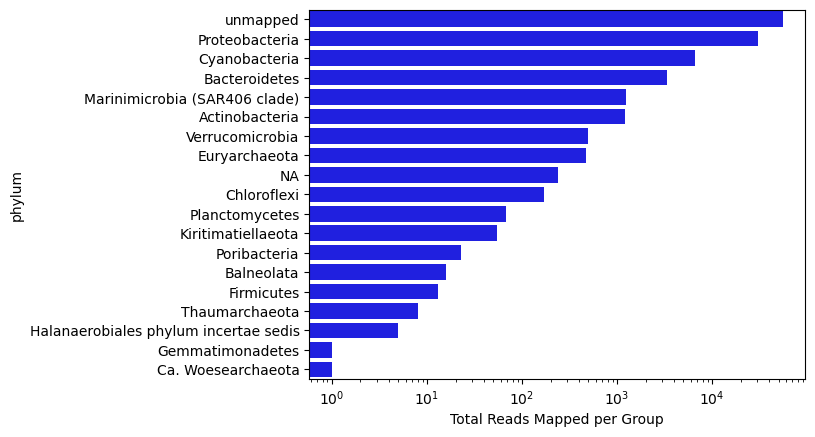

In [118]:
tax_level = 'phylum'

phycount = odf.groupby(tax_level, as_index = False)['read_id'].count().sort_values(by = 'read_id', ascending = False)
#tax_level = 'family'
#phycount = odf[odf['order'] == 'SAR11 clade'].groupby(tax_level, as_index = False)['read_id'].count().sort_values(by = 'read_id', ascending = False)

sns.barplot(x = phycount['read_id'], y = phycount[tax_level], color = 'blue')
plt.xscale('log')
plt.xlabel('Total Reads Mapped per Group')

Now let's scale up to check out the whole series of samples from the surface at BATS collected in 2004.

In [9]:
outs = glob.glob('/home/jovyan/shared/omics_tutorial/kaiju_results/results/*.out')
outs

['/home/jovyan/shared/omics_tutorial/kaiju_results/results/SRR5720337_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 '/home/jovyan/shared/omics_tutorial/kaiju_results/results/SRR5720338_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 '/home/jovyan/shared/omics_tutorial/kaiju_results/results/SRR5720342_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 '/home/jovyan/shared/omics_tutorial/kaiju_results/results/SRR5720256_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 '/home/jovyan/shared/omics_tutorial/kaiju_results/results/SRR5720257_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 '/home/jovyan/shared/omics_tutorial/kaiju_results/results/SRR5720278_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 '/home/jovyan/shared/omics_tutorial/kaiju_results/results/SRR5720307_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 '/home/jovyan/shared/omics_tutorial/kaiju_results/results/SRR5720321_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 '/home/jovyan/shared/omics_tutorial/kaiju_results/results/SRR5720260_100ksub_vs_GORGv1_kaiju_wtaxonomy.out',
 '/home/jo

In [119]:
def read_in_kaiju(outfile):
    library = op.basename(outfile).split("_")[0]
    df = pd.read_csv(outfile, 
                  sep = "\t", 
                  names = ['status','read_id','tax_id','taxonomy'])
    df['library'] = library
    for j, rank in enumerate('superkingdom,phylum,class,order,family,genus,species'.split(',')):
        df[rank] = df['taxonomy'].apply(lambda t: (get_rank(t, j)))
    df = df.fillna('unmapped')
    return df

tax_level = 'phylum'

combodf = pd.DataFrame()

for o in outs:
    df = read_in_kaiju(o)
    phycount = df.groupby(['library',tax_level], as_index = False)['read_id'].count()
    combodf = pd.concat([combodf, phycount])

Add sample information to dataframe

In [120]:
# Load sample information and pull out 'month' value for plotting

mg_metadata = pd.read_csv('data/bats_metagenomes_of_interest.csv')
mg_metadata[['year','month','day']] = mg_metadata['Collection_date'].str.split("-", expand = True)

mg_metadata['month'] = mg_metadata['month'].apply(pd.to_numeric)

# merging metadata table with the combined phylum counts

combodf = combodf.merge(mg_metadata, left_on = 'library', right_on = 'Run', how = 'left')

Text(0, 0.5, 'Reads Assigned to Phylum')

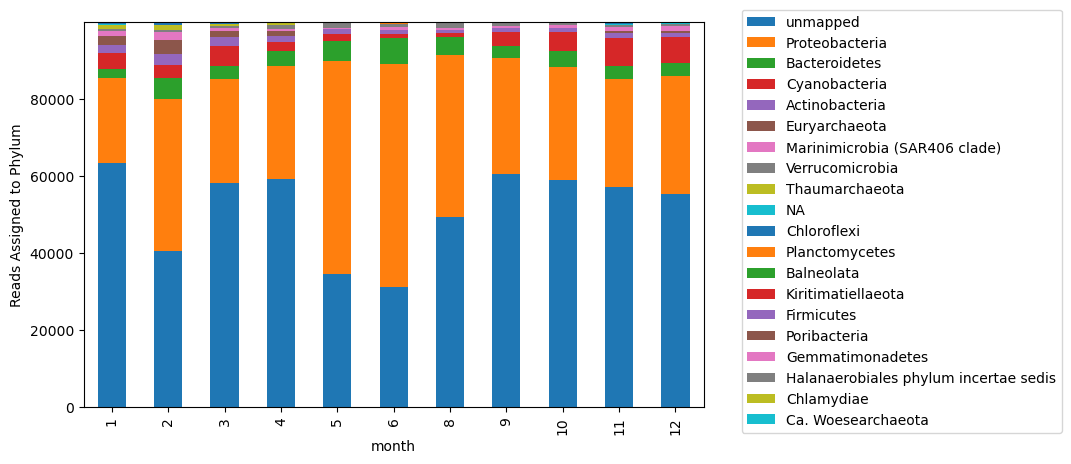

In [121]:
to_plot = combodf.groupby(['month','phylum'], as_index = False)['read_id'].sum().pivot(index = 'month', columns = 'phylum', values = 'read_id')

fig, ax = plt.subplots(figsize=(8,5))

# generating a list of phyla, ordered by abundance
column_order = list(combodf.groupby('phylum',as_index = False)['read_id'].sum().sort_values(by = 'read_id', ascending = False)['phylum'])

# ordering columns by abundance of different phyla
to_plot[column_order].plot.bar(stacked = True, ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1.05))
ax.set_ylabel('Reads Assigned to Phylum')

This is perhaps not helpful?  Too many taxa are included that are not well represented in the plot. Instead, let's identify the most represented taxa.

In [122]:
# identifying the top phyla to plot
total_phycounts = combodf.groupby('phylum',as_index = False)['read_id'].sum()

# keeping them as a list of top phyla, ordered by abundance
top_phyla = list(total_phycounts[total_phycounts['read_id'] > 500].sort_values(by = 'read_id', ascending = False)['phylum'])

# add column labelling top phyla and calling all others 'Other'
combodf['plot_phyla'] = [i if i in top_phyla else 'Other' for i in combodf['phylum']]

Text(0, 0.5, 'Reads Assigned to Phylum')

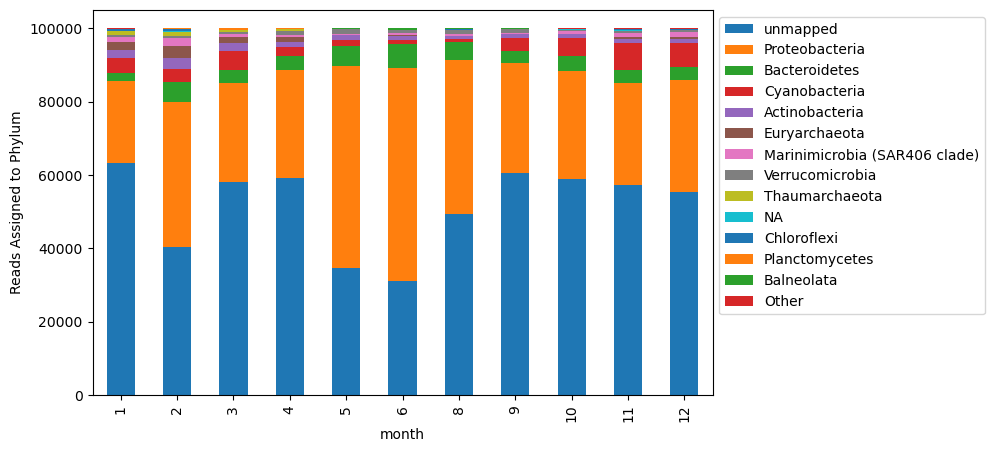

In [123]:
# group data by month and this new category, and create a pivot table for plotting
to_plot = combodf.groupby(['month','plot_phyla'], as_index = False)['read_id'].sum().pivot(index = 'month', columns = 'plot_phyla', values = 'read_id')

fig, ax = plt.subplots(figsize=(8,5))

column_order = top_phyla + ['Other']

to_plot[column_order].plot.bar(stacked = True, ax = ax)
plt.legend(bbox_to_anchor=(1, 1))
ax.set_ylabel('Reads Assigned to Phylum')

This essentially looks the same, but now our legend isn't crowded with all of the taxa present at low abundances in our samples.  

Something interesting we can see with this visualization is that there are variable numbers of unmapped reads. This could be due to a number of reasons. This variability influences the relative dynamics of taxa in this plot. 

An alternative is to calculate taxonomic distributions based on the abundance of only those reads that were assigned a taxonomy.

To do this, I'm going to remove the 'no assignment' column from the table, and consider the relative abundance of taxa based on the total reads that were assigned taxa overall.

Text(0, 0.5, 'Proportion Assigned Reads')

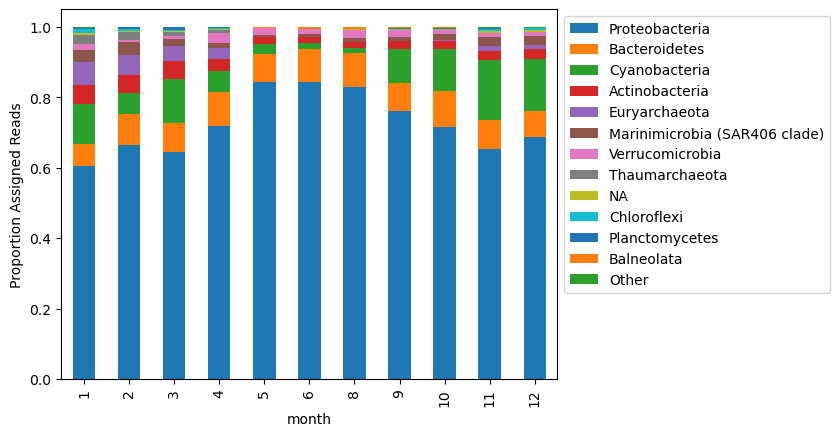

In [124]:
# remove the 'no assignment' column and calculate relative abundance of assigned reads only
new_mat = to_plot.drop(columns = 'unmapped')

# calculate relative abundance based on total reads recruited per sample
new_mat_ra = new_mat.div(new_mat.sum(axis = 1), axis = 0)

# plot
new_mat_ra[column_order[1:]].plot.bar(stacked = True)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Proportion Assigned Reads')

These two ways of normalizing counts show slightly different distributions!

Let's look at how dyanamics of the Phylum 'Proteobacteria' looks based on these two different visualizations.

Text(0.5, 0, 'Month')

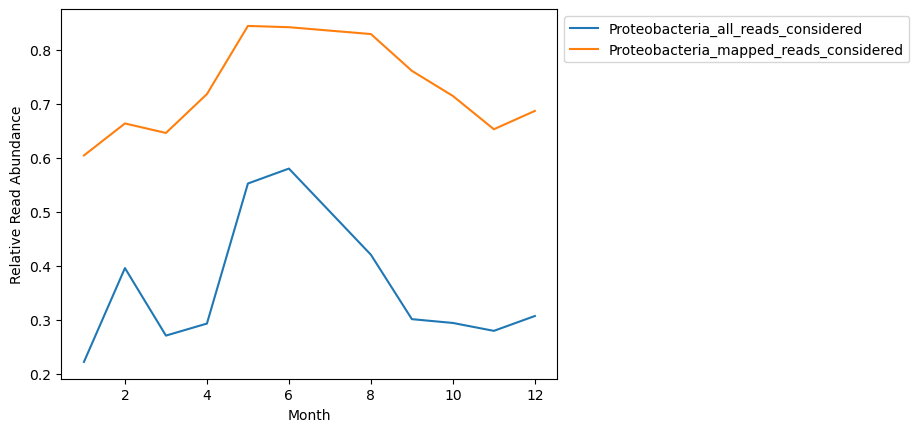

In [125]:
compdf = to_plot[['Proteobacteria']].copy().rename(columns = {'Proteobacteria':'Proteobacteria_all_reads_considered'})

# normalizing it to total reads considered so that it's comparable 
# because we subsampled our metagenomes prior to running Kaiju, we can divide all these counts by the same number of reads

compdf['Proteobacteria_all_reads_considered'] = compdf['Proteobacteria_all_reads_considered'] / 100000
compdf = compdf.merge(new_mat_ra[['Proteobacteria']].rename(columns = {'Proteobacteria':'Proteobacteria_mapped_reads_considered'}), 
                      left_index = True, right_index = True)

compdf.plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Relative Read Abundance')
plt.xlabel('Month')

The shape of distributions look similar but are not look entirely the same, and obviously show vastly different relative abundances. 

Ommitting the unmapped reads makes the assumption that the database being used is representative of microbial taxonomic diversity, even if it misses some of the read assignments. 

### PCA for beta diversity

Phylum-level taxonomic groups are not super informative for understanding the dynamics of microbial communities. It would be better to compare overall relationships of samples based on more granular taxonomic levels.

One way to do this is to use a dimensionality reduction method such as PCA. This gives an overall idea of the relationships in community structure between samples.  

First I am going to read in the output files from Kaiju like before, but now will consider the entirety of a taxonomic lineage, rather than Phylum-level taxonomic assignments.

In [127]:
outs = glob.glob('/home/jovyan/shared/omics_tutorial/kaiju_results/results/*.out')

def read_in_kaiju(outfile):
    library = op.basename(outfile).split("_")[0]
    df = pd.read_csv(outfile, 
                  sep = "\t", 
                  names = ['status','read_id','tax_id','taxonomy'])
    df['library'] = library
    for j, rank in enumerate('superkingdom,phylum,class,order,family,genus,species'.split(',')):
        df[rank] = df['taxonomy'].apply(lambda t: (get_rank(t, j)))
    df = df.fillna('unmapped')
    return df

tax_level = 'taxonomy'

combodf = pd.DataFrame()

for o in outs:
    df = read_in_kaiju(o)
    phycount = df.groupby(['library',tax_level], as_index = False)['read_id'].count()
    combodf = pd.concat([combodf, phycount])

As before, I'm adding some sample information to these data so that we can map the sequence collections back to the dates they were collected.

Then, I'll count reads assigned to each taxonomic category per sample, omit those reads where no taxonomy was assigned and create a matrix that contains the relative abundance of each taxonomic group per sample. 

In [129]:
combodf_w_metadata = combodf.merge(mg_metadata, left_on = 'library', right_on = 'Run', how = 'left')

# creating a pivot table with month as the index and taxonomy as the columns. NA values are zeros, but will substitute with 1 instead for eventual log transformation  
matdf = combodf_w_metadata.pivot(index = 'month', columns = 'taxonomy', values = 'read_id').fillna(1)

# consider only reads that were assigned an annotation in final count, calculate relative abundance (ar = annotated relative abundance)
armat = matdf.drop(columns = 'unmapped').div(matdf.drop(columns = 'unmapped').sum(axis = 1), axis = 0)
armat.head()

taxonomy,Archaea (superkingdom); Ca. Woesearchaeota; Pacearchaeota; NA; NA; NA; NA;,Archaea (superkingdom); Euryarchaeota; Thermoplasmata; Marine Group II; NA; NA; NA;,Archaea (superkingdom); Euryarchaeota; Thermoplasmata; Marine Group III; NA; NA; NA;,Archaea (superkingdom); Euryarchaeota; Thermoplasmata; NA; NA; NA; NA;,Archaea (superkingdom); Thaumarchaeota; Nitrososphaeria; Ca. Nitrosopumilales; Ca. Nitrosopelagicus family incertae sedis; Ca. Nitrosopelagicus; NA;,Archaea (superkingdom); Thaumarchaeota; Nitrososphaeria; Ca. Nitrosopumilales; Ca. Nitrosopumilus family incertae sedis; Ca. Nitrosopumilus; NA;,Archaea (superkingdom); Thaumarchaeota; Nitrososphaeria; Ca. Nitrosopumilales; NA; NA; NA;,Bacteria; Actinobacteria; Acidimicrobiia; Acidimicrobiales; NA; NA; NA;,Bacteria; Actinobacteria; Acidimicrobiia; Acidimicrobiales; OM1 clade; Candidatus Actinomarina; NA;,Bacteria; Actinobacteria; Acidimicrobiia; Acidimicrobiales; OM1 clade; NA; NA;,...,Bacteria; Verrucomicrobia; NA; NA; NA; NA; NA;,Bacteria; Verrucomicrobia; Opitutae; MB11C04 marine group; NA; NA; NA;,Bacteria; Verrucomicrobia; Opitutae; NA; NA; NA; NA;,Bacteria; Verrucomicrobia; Opitutae; Puniceicoccales; Puniceicoccaceae; Coraliomargarita; NA;,Bacteria; Verrucomicrobia; Opitutae; Puniceicoccales; Puniceicoccaceae; NA; NA;,Bacteria; Verrucomicrobia; Opitutae; Puniceicoccales; Puniceicoccaceae; marine group (Puniceicoccaceae); NA;,Bacteria; Verrucomicrobia; Verrucomicrobiae; Verrucomicrobiales; DEV007; NA; NA;,Bacteria; Verrucomicrobia; Verrucomicrobiae; Verrucomicrobiales; NA; NA; NA;,Bacteria; Verrucomicrobia; Verrucomicrobiae; Verrucomicrobiales; Rubritalecea; Roseibacillus; NA;,NA; NA; NA; NA; NA; NA; NA;
month,,,,,,,,,,,,,,,,,,,,,
1,0.000027,0.056736,0.006792,0.000027,0.024604,0.000245,0.001146,0.000027,0.029268,0.000273,...,0.000109,0.001037,0.000027,0.000136,0.000327,0.000136,0.005510,0.001337,0.000027,0.000164
2,0.000017,0.050026,0.007969,0.000017,0.020651,0.000151,0.000923,0.000017,0.036370,0.000302,...,0.000017,0.000419,0.000017,0.000101,0.000101,0.000084,0.001678,0.000352,0.000017,0.000201
3,0.000024,0.036509,0.004850,0.000024,0.009940,0.000215,0.000311,0.000024,0.039448,0.000239,...,0.000024,0.001290,0.000024,0.001219,0.000072,0.002700,0.000621,0.000143,0.000024,0.000239
4,0.000025,0.027693,0.003459,0.000025,0.009468,0.000172,0.000245,0.000025,0.028428,0.000294,...,0.000025,0.001153,0.000025,0.010326,0.000343,0.013589,0.001006,0.000196,0.000025,0.000098
5,0.000015,0.000061,0.000015,0.000015,0.000031,0.000015,0.000015,0.000015,0.019884,0.000061,...,0.000015,0.010209,0.000031,0.005120,0.000153,0.002613,0.000107,0.000046,0.000015,0.000031


To normalize the data, we'll preform a center-log-ratio transformation, which is common for phylogenetic comparisons of sample data such as this.  

The package skbio has a function for this ([see here](http://scikit-bio.org/docs/0.4.2/generated/skbio.stats.composition.html#module-skbio.stats.composition)), but we'll do it the old fashion way to see how it works more closely.

We will take the log of the above pivot table of relative abundances, and then subtract the mean per column.

In [130]:
# Calculate the geometric mean along each row
geom_mean = np.array(np.exp(np.mean(np.log(armat), axis=1)))

# Calculate the centered log-ratio transformation

clr_transformed = np.log(armat / geom_mean[:, np.newaxis])

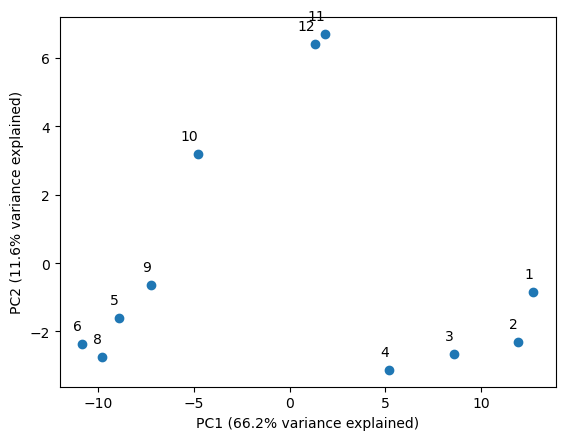

In [131]:
indf = clr_transformed

pca_components = 5
pca = PCA(n_components=pca_components)
fpca = pca.fit(indf)
X = pca.transform(indf)
(x_evr, y_evr) = fpca.explained_variance_ratio_[:2]

# establish point labels as the months
labels = list(matdf.index)

plt.scatter(x = X[:,0], y = X[:,1])

plt.xlabel('PC1 ({}% variance explained)'.format(round(x_evr * 100,1)))
plt.ylabel('PC2 ({}% variance explained)'.format(round(y_evr * 100,1)))

for i, label in enumerate(labels):
    plt.annotate(label, (X[i, 0], X[i, 1]), textcoords="offset points", xytext=(0,10), ha='right')


Here we've plotted the first two principal components. I've added the amount of variance explained to each component to the axis labels. This image tells a story of seasons, and raises some questions about what would happen if we added additional time series data to it. 





















That's all I have for this tutorial. There's only one more thing to say...

![HBD](tutorial_images/HBD.png)